In [1]:
import os


In [ ]:
data = pd.read_csv('../data/knn_data.csv', index_col=0)

In [2]:


#필요한 모듈 import

from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing import image
import os
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import pickle
import operator
import pandas as pd
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__')))+"/preprocessing")
#전처리 모듈
from Preprocessing import PreprocessingHashtags,DeleteLowFreqHashtags
from Tokenizer import Tokenizer


#코사인 유사도 구하기 위한 함수

@jit(nopython=True)
def cos_sim(a, b) :
    a_L2 = 0
    b_L2 = 0
    product = 0
    for i in range(7) :
        for j in range(7) :
            for k in range(512) :
                a_L2 += (a[0][i][j][k])**2
                b_L2 += (b[0][i][j][k])**2
                product += a[0][i][j][k] * 1.0 * b[0][i][j][k]

    return product / np.sqrt(a_L2 * b_L2)


class KNN_Classifier :
    #생성자에서는 descripter 생성을 위한 VGG19 model 을 생성해준다. (완전 분류 층을 제외하고 imagenet 데이터 학습되어 있음)
    def __init__(self) :
        self.model = VGG19(weights='imagenet', include_top = False, input_shape= (224,224,3))
        self.names_of_knn = []
        self.dic_of_knn = {}
        self.knn_csv = DeleteLowFreqHashtags(PreprocessingHashtags('../data/knn_data.csv'))
    
    #VGG19에 input 을 넣어주기 위한 전처리 과정
    def img_preprocess(self,img) :
        img = img_to_array(img)
        img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
        return img.copy()
        
    #target 이미지를 보여주는 코드    
    def show_target(self,target) :
        plt.imshow(target)
        plt.show()
     
    #KNN image 들을 VGG 모듈에 입력한 결과값들을 pickle에 저장해준다.
    #이는 나중에 target 이미지와 코사인유사도를 구할때 이용된다.
    def make_pickle(self) :
        file_list = os.listdir("../data/knn_img")
        pickle_dic = {}
        for file in file_list :
            if not file.count('JPEG') and not file.count('JPG') :
                file_list.remove(file)
        
        file_list.sort()
            
        for file in file_list :
            img = image.load_img('../data/knn_img/'+file,target_size=(224,224))
            img = self.img_preprocess(img)
            pickle_dic[file] = self.model.predict(img)
            
        with open("KNNClassifier_data.pickle","wb") as fw:
            pickle.dump(pickle_dic,fw)
     
    #저장해놓은 pickle 을 불러온다.
    def load_pickle(self) :
        with open("KNNClassifier_data.pickle","rb") as fr:
            self.pickle_dic = pickle.load(fr)
    
    #show_KNN 을 하여 target 이미지와 유사한 사진들을 보여주고, 이에 대한 정보를 딕셔너리에 저장한다.
    #공통 해시태그를 구하기 위해 필수로 불러주어야 하는 함수
    def show_KNN(self,target,sample_num) :
        self.dic_of_knn = {}
        self.names_of_knn = []
        sim_dic = {}
        for key,value in self.pickle_dic.items() :
            sim_dic[key] = cos_sim(target,value)
            
        sim_dic = dict(sorted(sim_dic.items(), key=operator.itemgetter(1), reverse=True)[:sample_num])
        self.dic_of_knn = sim_dic
        row = sample_num / 5 + 1
        fig = plt.figure(figsize = (24,10*row))
        ax_list = []
        for i,data in enumerate(sim_dic.items()) :
            self.names_of_knn.append(data[0])
            ax_list.append(fig.add_subplot(int(i/5) + 1,5,i%5 + 1))
            ax_list[i].set_title(data[1])
            ax_list[i].imshow(image.load_img('../data/knn_img/'+data[0] ,target_size = (224,224)))
            
        print(self.names_of_knn)
        
    #KNN으로 선정된 이미지들의 해시태그 리스트를 반환한다.    
    def get_hash_list(self) :
        hash_list = []
        hash_list_2 = []
        for name in self.names_of_knn :
            hash_list.append(self.knn_csv.loc[self.knn_csv['image_name'] == name]['hashtags'])
                
        hash_list_2 = []
        for data in hash_list :
            if len(data) :
                hash_list_2.append(data.iloc[0])
                
        return hash_list_2
    
    #KNN으로 선정된 이미지들의 공통 토큰을 추출한다 count_num 이상의 수만큼의 사진에서 태그된 토큰들을 추출
    def get_comm_token(self,count_num) :
        tf = pd.DataFrame()
        for name in self.names_of_knn :
            tf = tf.append(self.knn_csv.loc[self.knn_csv['image_name'] == name])
        
        tf.index = range(len(tf))
        token_list = Tokenizer(tf)
        
        set_list = []
        total_list = []
        comm_token = []
        
        for t_list in token_list :
            set_list.append(list(set(t_list)))
        
        for s_list in set_list :
            total_list += s_list
    
        for token in total_list :
            count = 0
            for s_list in set_list :
                count += s_list.count(token)
            
            if count >= count_num :
                comm_token.append(token)

        return list(set(comm_token))
        




In [4]:
knn = KNN_Classifier()

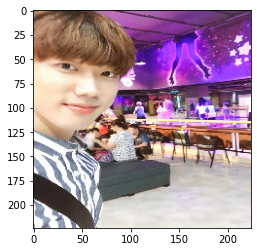

In [5]:
target = image.load_img('../data/test_3.jpg',target_size = (224,224))
knn.show_target(target)

In [6]:
knn.load_pickle()

In [7]:
tar = knn.img_preprocess(target)
tar = knn.model(tar)

['오오티디_38.jpg', '강남_67.jpg', '셀피_7.jpg', '불금_1.jpg', '데일리룩_66.jpg']


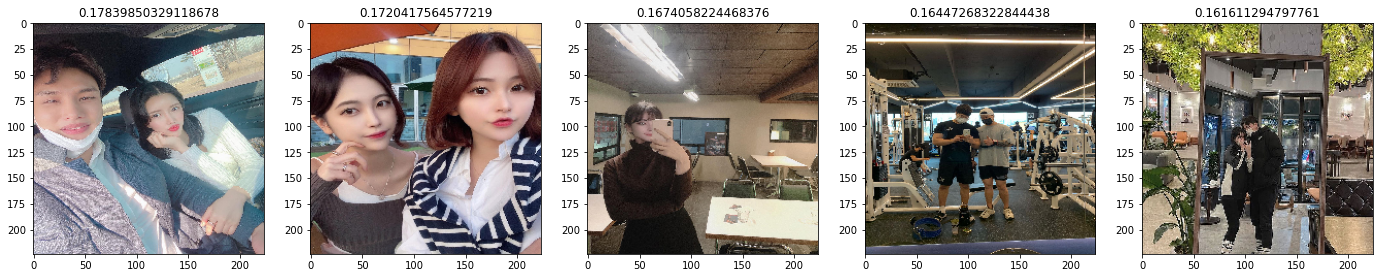

In [8]:
knn.show_KNN(tar,5)

In [12]:
!git clone https://github.com/lovit/customized_konlpy.git
!pip install customized_konlpy

Cloning into 'customized_konlpy'...
remote: Enumerating objects: 618, done.
remote: Total 618 (delta 0), reused 0 (delta 0), pack-reused 618
Receiving objects: 100% (618/618), 950.06 KiB | 7.79 MiB/s, done.
Resolving deltas: 100% (345/345), done.
     |████████████████████████████████| 881 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 19.4 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 378 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 8.6 MB/s  eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-4.9.3


In [13]:
knn.get_comm_token(2)

/Users/pdh/opt/anaconda3/lib/python3.8/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


FileNotFoundError: [Errno 2] No such file or directory: 'modeling/UserDic.txt'

In [10]:
!pip3 install ckonlpy

ERROR: Could not find a version that satisfies the requirement ckonlpy (from versions: none)
ERROR: No matching distribution found for ckonlpy
